# Unsupervised Segmentation of DAPI dataset

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import torch
import genus as gn
import numpy
from genus.util_data import  DataloaderWithLoad, ConditionalRandomCrop, DatasetInMemory
from genus.util import linear_interpolation, append_to_dict, ckpt2file, load_yaml_as_dict, load_obj
from genus.util_vis import show_batch
from genus.model import CompositionalVae, instantiate_optimizer, instantiate_scheduler, process_one_epoch
from functools import partial
import torchvision
from torchvision import transforms

In [5]:
config_file = "./config_VQVAE.yaml"
config = load_yaml_as_dict(config_file)
BATCH_SIZE = config["simulation"]["BATCH_SIZE"]

In [6]:
# We transform them to tensors
transform = transforms.ToTensor()

train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Load and transform data
train_data = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)


train_dataset = DatasetInMemory(x=train_data.data.unsqueeze(-3).float()/(255.0),
                                y=train_data.targets,
                                store_in_cuda=False)
test_dataset = DatasetInMemory(x=test_data.data.unsqueeze(-3).float()/(255.0),
                               y=test_data.targets,
                               store_in_cuda=False)

BATCH_SIZE = 8
test_loader = DataloaderWithLoad(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataloaderWithLoad(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Create the dataloader as usual

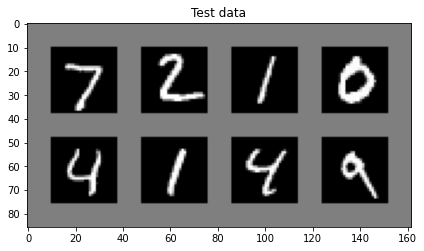

In [7]:
img, _, _ = test_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Test data",  pad_value=0.5, n_padding=10)

In [8]:
config_file = "./config_VQVAE.yaml"
config = load_yaml_as_dict(config_file)

In [29]:
from typing import NamedTuple, Optional

from genus.encoders_decoders import EncoderConv, DecoderConv
from genus.namedtuple import Output, MetricMiniBatch
    
class ZZ(NamedTuple):
    z: torch.Tensor
    zq: torch.Tensor
    
class NewEncoderConv(torch.nn.Module):
    def __init__(self, size: int, ch_in: int, dim_z: int):
        super().__init__()
        self.ch_in = ch_in
        self.width = size
        self.dim_z = dim_z
        assert size==32

        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=self.ch_in, out_channels=16, kernel_size=4, stride=1, padding=2),  # 32,32
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),  # 16,16
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),  # 8,8
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=64, out_channels=self.dim_z, kernel_size=4, stride=2, padding=1),  # 4,4
        )

    def forward(self, x: torch.Tensor):
        return self.conv(x)
    
class NewDecoderConv(torch.nn.Module):
    def __init__(self, size: int, ch_out: int, dim_z: int):
        super().__init__()
        self.ch_out = ch_out
        self.width = size
        self.dim_z = dim_z
        assert size==32
        
        self.upconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=self.dim_z, out_channels=16*self.ch_out, kernel_size=4, stride=2, padding=1),  # 4,4
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=16*self.ch_out, out_channels=8*self.ch_out, kernel_size=4, stride=2, padding=1),  # 8,8
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=8*self.ch_out, out_channels=4*self.ch_out, kernel_size=4, stride=2, padding=1),  # 16,16
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=4*self.ch_out, out_channels=self.ch_out, kernel_size=4, stride=2, padding=1),  # 32,32
        )

    def forward(self, z: torch.Tensor):
        return self.upconv(z)
    
    

class VQVAE(torch.nn.Module):
    def __init__(self, ch_img: int, dim_z: int, codebook_size: int) -> None:
        super().__init__()
        self.vq_beta = 0.25
        self.dim_z = dim_z
        self.codebook_size = codebook_size
        self.ch_img = ch_img
        self.encoder = NewEncoderConv(size=32, ch_in=self.ch_img, dim_z=self.dim_z)
        self.decoder = NewDecoderConv(size=32, ch_out=self.ch_img, dim_z=self.dim_z)
        self.embedding_KZ = torch.nn.Embedding(self.codebook_size, self.dim_z)
        self.embedding_KZ.weight.data.uniform_(-1.0 / self.codebook_size, 1.0 / self.codebook_size)
        
        if torch.cuda.is_available():
            self.cuda()
    
    def _d2(self, a, b, dim):
        return (a-b).pow(2).sum(dim=dim)
    
    def forward(self, imgs_in, 
                iom_threshold=None, 
                noisy_sampling=None, 
                draw_image=False,
                draw_bg=False,
                draw_boxes=False,
                draw_boxes_ideal=False,
                verbose=False):
        x = torch.nn.functional.pad(imgs_in, pad=[2,2,2,2], mode='constant', value=0)
        print("x.shape",x.shape)
        
        z = self.encoder(x) # B, w, h, dim_z
        print("z.shape",z.shape)
        
        d_bwhk = self._d2(z.permute(0,2,3,1).unsqueeze(-2), self.embedding_KZ.weight, dim=-1)
        print("d_bwhk.shape", d_bwhk.shape)
        
        j_bwh = d_bwhk.min(dim=-1)[1]
        print("j_bwh.shape", j_bwh.shape)
        zq = self.embedding_KZ.weight[j_bwh,:].permute(0,3,1,2)
        print("zq.shape", zq.shape)
        imgs_out = self.decoder(zq)
        
        rec = ((x-imgs_out)/0.1).pow(2).mean()
        loss = rec + self._d2(z.detach(), zq).mean() + self.vq_beta * self._d2(z, zq.detach()).mean()
        return Output(metrics=MetricMiniBatch(loss=loss.mean(),
                                              mse_av=rec,
                                              count_prediction=-1*numpy.ones(1),
                                              wrong_examples=-1*numpy.ones(1),
                                              accuracy=-1.0),
                      inference=ZZ(z=z, zq=zq), 
                      imgs=imgs_out, 
                      bb_imgs=imgs_in)
        
        
vae = VQVAE(ch_img=1, dim_z=20, codebook_size=256)

if torch.cuda.is_available():
    img = img.cuda()
    
a = vae(img, verbose=True)

x.shape torch.Size([8, 1, 32, 32])
z.shape torch.Size([8, 20, 4, 4])
d_bwhk.shape torch.Size([8, 4, 4, 256])
j_bwh.shape torch.Size([8, 4, 4])
zq.shape torch.Size([8, 20, 4, 4])


RuntimeError: The size of tensor a (32) must match the size of tensor b (64) at non-singleton dimension 3

In [ ]:
show_batch(a.imgs)

### Instantiate the model, optimizer and scheduler

In [ ]:
#vae = CompositionalVae(config)
optimizer = instantiate_optimizer(model=vae, config_optimizer=config["optimizer"])

if config["simulation"]["type"] == "scratch":
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999

elif config["simulation"]["type"] == "resume":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=optimizer,
                   overwrite_member_var=True)

    epoch_restart = ckpt.get('epoch', -1)
    history_dict = ckpt.get('history_dict', {})
    try:
        min_test_loss = min(history_dict.get("test_loss", 999999))
    except:
        min_test_loss = 999999

elif config["simulation"]["type"] == "pretrained":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=None,
                   overwrite_member_var=False)
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999
    
else:
    raise Exception("simulation type is NOT recognized")
    
# instantiate the scheduler if necessary    
if config["scheduler"]["is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, config_scheduler=config["scheduler"])
else:
    scheduler = None

### Training loop

In [ ]:
TEST_FREQUENCY = config["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = config["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = config["simulation"]["MAX_EPOCHS"]

for epoch in range(1,NUM_EPOCHS+1):
    
    
    vae.train()
    train_metrics = process_one_epoch(model=vae,
                                      dataloader=train_loader,
                                      optimizer=optimizer,
                                      scheduler=scheduler,
                                      iom_threshold=config["architecture"]["nms_threshold_train"],
                                      verbose=(epoch == 0))
    
    with torch.no_grad():
        print("Train " + train_metrics.pretty_print(epoch))
        history_dict = append_to_dict(source=train_metrics,
                                      destination=history_dict,
                                      prefix_exclude="wrong_examples",
                                      prefix_to_add="train_")
        
        if (epoch % TEST_FREQUENCY) == 0:
            vae.eval()
            test_metrics = process_one_epoch(model=vae,
                                             dataloader=test_loader,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             iom_threshold=config["architecture"]["nms_threshold_test"],
                                             verbose=(epoch == 0))
            print("Test  "+test_metrics.pretty_print(epoch))
            history_dict = append_to_dict(source=test_metrics,
                                          destination=history_dict,
                                          prefix_exclude="wrong_examples",
                                          prefix_to_add="test_")
            
        if (epoch % CHECKPOINT_FREQUENCY == 0) and (epoch >= 20):
            ckpt = vae.create_ckpt(optimizer=optimizer,
                                   epoch=epoch,
                                   history_dict=history_dict)
            ckpt2file(ckpt=ckpt, path="last_ckpt_"+str(epoch))

In [ ]:
output = vae(img)

In [ ]:
show_batch(output.imgs)

### Visualize the results (for example MSE)

In [ ]:
plt.imshow()